# Deep Learning for Anomaly Detection on Machine Temperature Data

This notebook demonstrates how to build and evaluate an LSTM Autoencoder for anomaly detection using the NAB machine temperature dataset.  
The model is trained on normal operating data and uses reconstruction errors to flag anomalies.  
Evaluation covers both point-level detection accuracy and anomaly window–based metrics, reflecting industrial needs for early fault detection.


## Setup

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sys
import os
import pathlib


repo_root = pathlib.Path.cwd().resolve().parents[1]  
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from configs.config import DEFAULTS
from src.data_loader import load_dataset
from src.detectors_dl import train_autoencoder, ae_scores, windows_to_pointwise_last
from src.visualizations import plot_methods_subplots, shade_windows
from src.evaluation import evaluate_predictions


In [22]:
torch.manual_seed(42)

In [23]:
dfs, merged, windows = load_dataset("machine_temperature")
df = dfs[0]

## Preprocessing

Time-series data is transformed into sliding windows of fixed length to capture temporal dependencies.  

### Time-based spliting
Data is split into train, validation, and test segments by timestamp.  
A strict chronological split avoids look-ahead bias, ensuring that test performance reflects generalization to future data.

In [24]:
# Split by time (60/20/20) to simulate realistic streaming
n = len(df)
t1 = int(0.6 * n)
t2 = int(0.8 * n)

train_df = df.iloc[:t1].copy()
val_df   = df.iloc[t1:t2].copy()
test_df  = df.iloc[t2:].copy()

### Excluding anomalies from trainign
The model is trained only on normal segments (outside failure windows). This ensures the autoencoder is trained solely on normal, healthy behavior, preventing it from learning patterns associated with failures and preserving the model’s ability to generalize to unseen anomalies.


In [25]:
def in_any_failure_window(ts, windows):
    for s, e in windows:
        if s <= ts <= e:
            return True
    return False

# Mark timestamps inside windows
train_df["in_window"] = train_df["timestamp"].apply(lambda t: in_any_failure_window(t, windows))
val_df["in_window"] = val_df["timestamp"].apply(lambda t: in_any_failure_window(t, windows))
test_df["in_window"] = test_df["timestamp"].apply(lambda t: in_any_failure_window(t, windows))

### Sequences
The time series is converted into fixed-length windows to provide temporal context.  
- **Window length (T)**: defines the temporal horizon of patterns captured.  
  - Short windows → fine-grained detection, but less stability.  
  - Long windows → smoother errors, but risk delayed detection.  

In [26]:
def make_sequences(df, seq_len, value_col, use_only_normal=True):
    x = df[value_col].to_numpy(dtype=np.float32)
    ts = df["timestamp"].to_numpy()
    inw = df["in_window"].to_numpy(dtype=bool)

    seqs = []
    idxs = []
    for i in range(len(df) - seq_len + 1):
        seg_inw = inw[i:i+seq_len]
        if use_only_normal and seg_inw.any():
            continue
        seq = x[i:i+seq_len].copy()
        seqs.append(seq[:, None])  # shape (seq_len, 1)
        idxs.append(i + seq_len - 1)  # align to last timestamp for scoring
    return np.stack(seqs) if len(seqs)>0 else np.empty((0, seq_len, 1), dtype=np.float32), np.array(idxs)

In [27]:
SEQ_LEN = DEFAULTS['dl']['autoencoder']['seq_len']
Xtr, tr_idx = make_sequences(train_df, SEQ_LEN, value_col ='machine_temperature_system_failure', use_only_normal=True)
Xva, va_idx = make_sequences(val_df,   SEQ_LEN, value_col ='machine_temperature_system_failure', use_only_normal=True)
Xte, te_idx = make_sequences(test_df,  SEQ_LEN, value_col ='machine_temperature_system_failure', use_only_normal=False)

print("Train seqs:", Xtr.shape, "Val seqs:", Xva.shape, "Test seqs:", Xte.shape)

Train seqs: (12186, 100, 1) Val seqs: (3774, 100, 1) Test seqs: (4440, 100, 1)


### Feature scaling
Scaling is applied to stabilize training and prevent large-valued features from dominating the loss.  
- Mean/standard deviation are computed **only on the training set** (normal data only) and applied to all splits.  
- Using statistics from the full dataset or from windows containing anomalies would introduce information leakage.  


In [28]:
# Standardize using training stats
mu = Xtr.mean()
sd = Xtr.std() if Xtr.std() > 0 else 1.0
Xtr_n = (Xtr - mu)/sd
Xva_n = (Xva - mu)/sd
Xte_n = (Xte - mu)/sd
mu, sd

(np.float32(88.56737), np.float32(9.100278))

## Model Architecture and Training
The LSTM Autoencoder is designed to capture temporal dynamics in the machine temperature dataset.  
- The **encoder** compresses each input sequence into a low-dimensional latent representation, forcing the model to extract the most informative features.  
- The **decoder** reconstructs the sequence from this latent space, enabling a direct comparison between expected and actual patterns.  


### Configurations
The configuration is printed below, and each setting has a specific role. 
- The length of the input sequence decides how much history the model sees: shorter sequences make the model more responsive, while longer ones give it more stability. 
- The batch size controls how many sequences are processed at once, which affects both training speed and how smooth the learning is.
- The size of the hidden layer shows how much detail the model can capture, and the depth of the network decides how complex the learned patterns can be. 
- Dropout is used to reduce overfitting. 
- The number of training epochs limits how long the model runs, and early stopping ends training when improvements stop.  



In [29]:
cfg = DEFAULTS 

SEQ_LEN = cfg["dl"]["autoencoder"]["seq_len"] 
BATCH = cfg["dl"]["autoencoder"]["batch_size"] 
EPOCHS = cfg["dl"]["autoencoder"]["epochs"] 
HID = cfg["dl"]["autoencoder"]["hidden"] 
LAYERS = cfg["dl"]["autoencoder"]["layers"] 
DROP = cfg["dl"]["autoencoder"]["dropout"] 
DECAY = cfg["dl"]["autoencoder"]["weight_decay"] 
LR = cfg["dl"]["autoencoder"]["lr"] 
EPOCHS = cfg["dl"]["autoencoder"]["epochs"] 
PATIENCE = cfg["dl"]["autoencoder"]["patience"]

print(
    "LSTM Autoencoder Configuration:\n"
    f"  Sequence length   : {SEQ_LEN}\n"
    f"  Batch size        : {BATCH}\n"
    f"  Hidden units      : {HID}\n"
    f"  Layers            : {LAYERS}\n"
    f"  Dropout           : {DROP}\n"
    f"  Weight decay      : {DECAY}\n"
    f"  Learning rate     : {LR}\n"
    f"  Epochs (max)      : {EPOCHS}\n"
    f"  Early stop patience: {PATIENCE}"
)


LSTM Autoencoder Configuration:
  Sequence length   : 100
  Batch size        : 32
  Hidden units      : 64
  Layers            : 2
  Dropout           : 0.1
  Weight decay      : 0.0
  Learning rate     : 0.001
  Epochs (max)      : 50
  Early stop patience: 5


### Training

`train_autoencoder` fits an LSTM autoencoder on normalized training sequences and tracks validation loss for early stopping and configuration-driven tuning.  

In [30]:
n_features = 1 # univariate time series
model, history = train_autoencoder(Xtr_n, Xva_n, n_features, cfg['dl']['autoencoder'], verbose=True)

Epoch 1/50 | train=0.912778 val=1.518179
Epoch 2/50 | train=0.494936 val=0.968663
Epoch 3/50 | train=0.373509 val=0.860706
Epoch 4/50 | train=0.325855 val=0.796877
Epoch 5/50 | train=0.290097 val=0.774191
Epoch 6/50 | train=0.262290 val=0.758486
Epoch 7/50 | train=0.243599 val=0.748809
Epoch 8/50 | train=0.233895 val=0.743446
Epoch 9/50 | train=0.229746 val=0.739711
Epoch 10/50 | train=0.227000 val=0.736867
Epoch 11/50 | train=0.225171 val=0.734928
Epoch 12/50 | train=0.223870 val=0.733928
Epoch 13/50 | train=0.222841 val=0.732532
Epoch 14/50 | train=0.222115 val=0.731753
Epoch 15/50 | train=0.221362 val=0.731294
Epoch 16/50 | train=0.220852 val=0.730920
Epoch 17/50 | train=0.220454 val=0.729865
Epoch 18/50 | train=0.220190 val=0.729223
Epoch 19/50 | train=0.219788 val=0.729237
Epoch 20/50 | train=0.219459 val=0.728925
Epoch 21/50 | train=0.219345 val=0.728909
Epoch 22/50 | train=0.219259 val=0.728198
Epoch 23/50 | train=0.219068 val=0.728052
Epoch 24/50 | train=0.218847 val=0.727904
E

## Evaluation and Results

Reconstruction error is used as the anomaly score.  
Normal sequences have low errors, while anomalous sequences produce higher values.  

### Threshold selection

Validation sequences are scored with the last_t reduction, assigning each sequence’s error to its final timestep.  
A high-quantile cutoff from the validation distribution is chosen as the operating threshold and then applied to the test scores.


In [31]:
REDUCE = 'last_t'

# score validation windows and pick a high-quantile
val_scores = ae_scores(model, Xva_n, cfg, reduce=REDUCE)   
thr = np.quantile(val_scores, 0.95) 

print('Threshold: ', thr)

Threshold:  5.8947096


### Anomaly detection on the test set

The above threshold applied to the test scores to produce a boolean anomaly series, where values above the cutoff are marked as anomalies. Because last_t aligns detections to the sequence end.

In [32]:
test_scores = ae_scores(model, Xte_n, cfg, reduce=REDUCE)   
test_anomay_mask = (test_scores > thr).astype(bool)

The predicted anomaly mask is plotted with the labeled failure interval.

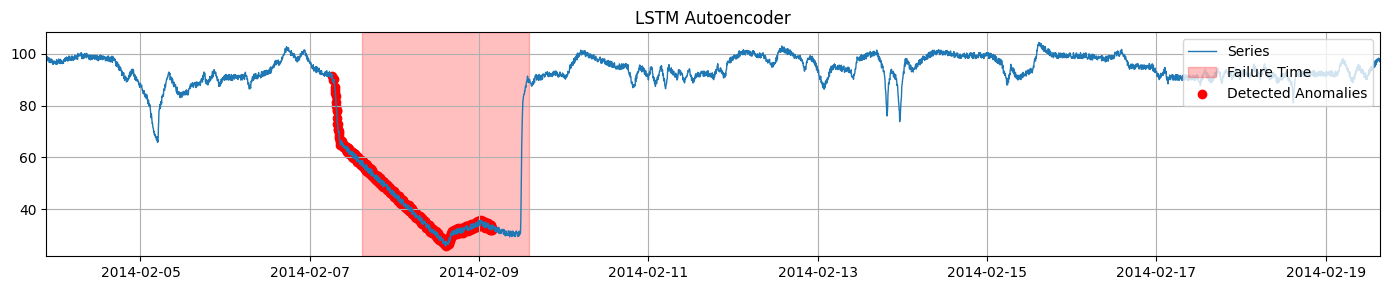

In [33]:
methods_preds = {'LSTM Autoencoder': test_anomay_mask}
plot_methods_subplots(test_df, methods_preds, offset =t2, value_col="machine_temperature_system_failure", windows=windows)

The above plot overlays the predicted anomaly markers (red points) on the measured temperature series, with the labeled failure interval shown as a shaded band.  
Detections cluster inside the shaded interval, indicating good coverage during the failure period.  
No markers appear far before the onset, so early warnings are limited to near-onset behavior in this run.  


In [34]:
test_preds = [False] * len(test_df)
test_preds[SEQ_LEN-1:] = test_anomay_mask

In [35]:
eval_results = {'LSTM Autoencoder': evaluate_predictions(test_df, test_preds , windows, early_tolerance="5h")}        
print(pd.DataFrame(eval_results).T.round(3))

                     tp   fp    fn      tn  precision  recall     f1  \
LSTM Autoencoder  539.0  1.0  28.0  3971.0      0.998   0.951  0.974   

                  anomaly_window_detection_rate  early_detection_rate  
LSTM Autoencoder                            1.0                   1.0  


Point-level results show near-perfect precision with high recall, indicating very few false alarms and only a small number of missed anomaly points. The combined F1 score reflects strong overall separation between normal and abnormal behavior. 

At the window level, the single labeled failure interval is detected on time, providing full coverage under the chosen early-tolerance setting.